In [83]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.algorithms.moo.nsga2 import NSGA2

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints, CalculateMultiCriteriaProblem, MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory, get_horizontal_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward, MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward

from auto_robot_design.generator.user_generator.graph_generator import TopologyManager2D
from auto_robot_design.description.kinematics import JointPoint

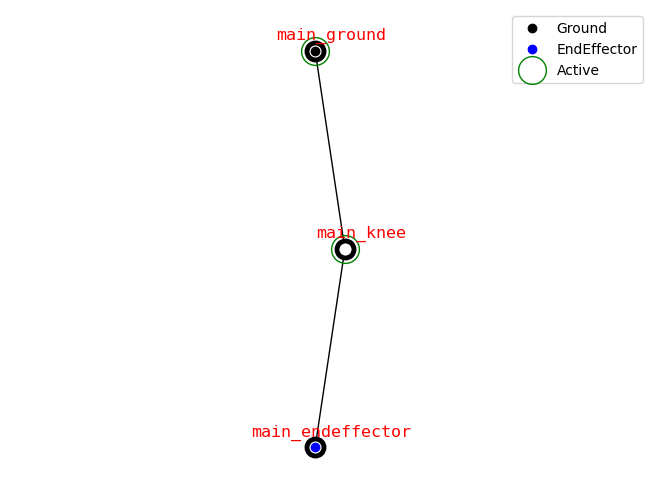

In [84]:
tp = TopologyManager2D()
# creates ground connection
main_ground_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=True, name='main_ground',attach_ground=True, attach_endeffector=False)
tp.add_absolute_node(jp=main_ground_jp, initial_coordinates=np.array([0, 0, 0]), mutation_range=[None,None,None], freeze_pos=np.array([0,0,0]))
main_knee_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=True, name='main_knee', attach_ground=False, attach_endeffector=False)
tp.add_absolute_node(jp=main_knee_jp, parent_branch_idx=0, initial_coordinates=[0.03, 0, -0.2], mutation_range=[None,None,(-0.1,0.1)], freeze_pos=np.array([0.03,0,None]))
# creates connection on the first link
tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.4,0.4)], dependent_mutation_range=[(-0.1,0.1),None,(-0.1,0.1)])
main_endeffector_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_endeffector',attach_ground=False, attach_endeffector=True)
tp.add_absolute_node(jp=main_endeffector_jp, parent_branch_idx=0, initial_coordinates=np.array([0.0, 0, -0.4]), mutation_range=[None,None,None], freeze_pos=np.array([0.,0,-0.4]))

tp.set_mutation_ranges()
graph = tp.get_graph(tp.generate_central_from_mutation_range())
draw_joint_point(graph)

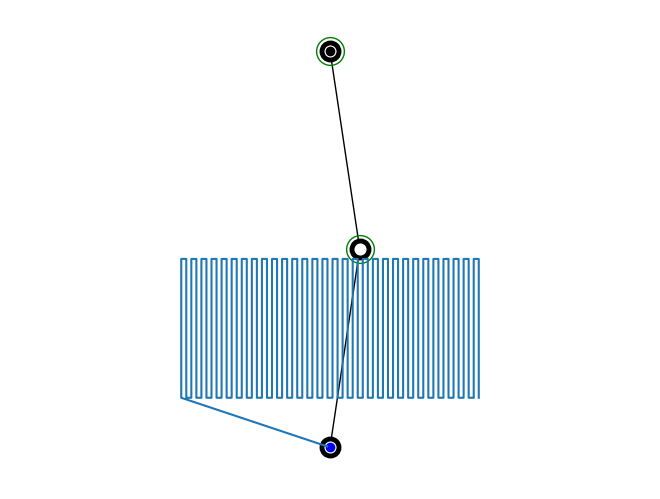

In [85]:
from auto_robot_design.utils.configs import inertial_config_two_link_workspace, get_mesh_builder

builder, crag, soft_constrain, reward_manager = inertial_config_two_link_workspace()

draw_joint_point(graph,draw_labels=False)
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

#plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [86]:
import ipywidgets as widgets
import meshcat
from pinocchio.visualize import MeshcatVisualizer
from IPython.display import display, clear_output, HTML, IFrame, Image
from auto_robot_design.description.mesh_builder.urdf_creater import (
    URDFMeshCreator,
    MeshCreator,
)
from auto_robot_design.description.mesh_builder.mesh_builder import (
    MeshBuilder,
    jps_graph2pinocchio_meshes_robot,
)
import pinocchio as pin
import time
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager


mesh_builder = get_mesh_builder()
output = widgets.Output()

fixed_robot, free_robot = jps_graph2pinocchio_meshes_robot(tp.graph, mesh_builder)
visualizer = MeshcatVisualizer(
    fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model
)
with output:
    visualizer.viewer = meshcat.Visualizer()
visualizer.viewer["/Background"].set_property("visible", False)
visualizer.viewer["/Grid"].set_property("visible", False)
visualizer.viewer["/Axes"].set_property("visible", False)
visualizer.viewer["/Cameras/default/rotated/<object>"].set_property(
    "position", [0, 0.0, 0.8]
)
visualizer.clean()
visualizer.loadViewerModel()
visualizer.display(pin.neutral(fixed_robot.model))
with output:
    output.clear_output(wait=True)
    display(IFrame(src=visualizer.viewer.url(), width="400px", height="400px"))

#output.append_display_data(IFrame(src=visualizer.viewer.url(), width="400px", height="400px"))

def run_simulation(b):
    global tp
    ik_manager = TrajectoryIKManager()
    ik_manager.set_solver('Open_Loop')
    # fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph, builder)
    fixed_robot, free_robot = jps_graph2pinocchio_meshes_robot(tp.graph, mesh_builder)
    ik_manager.register_model(
        fixed_robot.model, fixed_robot.constraint_models, fixed_robot.visual_model
    )
    #ik_manager.set_solver("Closed_Loop_PI")
    poses, q_fixed, constraint_errors, reach_array = ik_manager.follow_trajectory(
        trajectory, viz=visualizer
    )
    time.sleep(0.5)
    visualizer.display(pin.neutral(fixed_robot.model))

first_run_button = widgets.Button(description='run simulation', layout=widgets.Layout(width='200px', height='40px')) 
first_run_button.style.button_color = 'lightblue'
first_run_button.on_click(run_simulation)
display(output, first_run_button)

Output()

Button(description='run simulation', layout=Layout(height='40px', width='200px'), style=ButtonStyle(button_col…

In [87]:
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)


In [88]:
population_size = 128
n_generations = 10

# create the problem for the current optimization
problem = MultiCriteriaProblem(tp, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=builder.actuator['default'])

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
#algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
algorithm =NSGA2(pop_size=population_size)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 3,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

     1 |      128 |     62 |  0.0799376738 |         ideal
     2 |      256 |    128 |  0.0441215963 |         ideal
     3 |      384 |    128 |  0.0622680791 |         ideal
     4 |      512 |    128 |  0.0036430760 |         ideal
     5 |      640 |    128 |  0.0018162148 |             f
     6 |      768 |    128 |  0.0030603120 |             f
     7 |      896 |    128 |  0.0020702304 |             f
     8 |     1024 |    128 |  0.0028053521 |             f
     9 |     1152 |    128 |  0.0017707042 |             f
    10 |     1280 |    128 |  0.0027291068 |             f


Scale f1: [-1.5139711441265211, -1.153815454542637]
Scale f2: [-5.091745214533023, -3.9130659334402544]


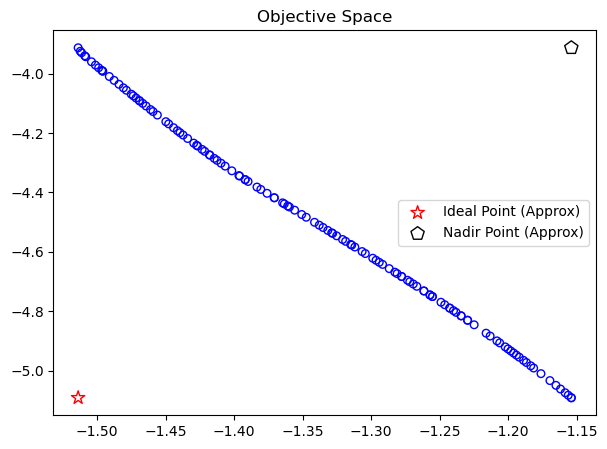

In [89]:
F = res.F
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none',
            edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none',
            edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()

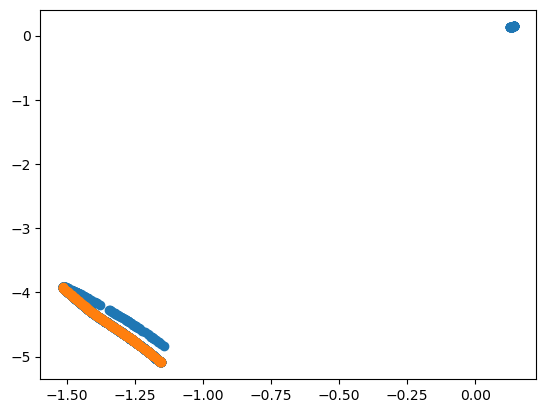

In [110]:
optimizer.history["F"]
plt.scatter(np.array(optimizer.history["F"])[:,0], np.array(optimizer.history["F"])[:,1])
#plt.scatter(np.array(optimizer.history["F"])[100:200,0], np.array(optimizer.history["F"])[100:200,1])
#plt.scatter(np.array(optimizer.history["F"])[200:300,0], np.array(optimizer.history["F"])[200:300,1])
plt.scatter(res.F[:,0], res.F[:,1])

In [91]:
optimizer.history["F"]

[array([-1.50675275, -3.91637656]),
 array([-1.44829818, -4.03400515]),
 array([-1.47851603, -4.05689915]),
 array([-1.51214266, -3.90997545]),
 array([-1.28262837, -4.42924365]),
 array([-1.27812346, -4.44096502]),
 array([-1.35714387, -4.4563896 ]),
 array([-1.43402366, -4.21857355]),
 array([-1.24261214, -4.78973132]),
 array([-1.5130358 , -3.92147794]),
 array([-1.2010841, -4.9237455]),
 array([-1.51378117, -3.91623727]),
 array([-1.47767669, -3.97161374]),
 array([-1.47322026, -4.07647018]),
 array([-1.46517499, -3.99795893]),
 array([-1.49769045, -3.9319617 ]),
 array([-1.18871451, -4.96576732]),
 array([-1.5052435 , -3.91879979]),
 array([-1.46436261, -4.10919824]),
 array([-1.51066204, -3.933426  ]),
 array([-1.47538597, -4.06846053]),
 array([-1.45668159, -4.01582254]),
 array([-1.51300395, -3.92166846]),
 array([-1.39352773, -4.35263154]),
 array([-1.50787637, -3.9146732 ]),
 array([-1.39821112, -4.14633155]),
 array([-1.48451535, -4.03466634]),
 array([-1.44369292, -4.184404

In [92]:
res.F[0]

array([-1.15381545, -5.09174521])

In [102]:
len(res.F)

128

In [103]:
len(res.X)

128

In [95]:
len(res.F)

128

In [96]:
res.pop[0].F

array([-1.15381545, -5.09174521])

In [104]:
v = []
for i in range(128):
    v.append(res.F[i]-res.pop[i].F)

np.array(v).max(axis=0)

array([0., 0.])

In [108]:
last = np.array(optimizer.history["F"])[1152:1280,:]
v = []
for i in range(128):
    v.append(last[i]-res.pop[i].F)

np.array(v).max(axis=0)

array([1.64413992, 5.03526827])